# Generate Search Summary
This notebook retrieves different subsets of the search and dumps them into a spreadsheet

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from moldesign.store.mongo import MoleculePropertyDB
from moldesign.store.models import MoleculeData
from moldesign.store.recipes import redox_recipes
from rdkit.Chem import Descriptors
from rdkit import Chem
from pathlib import Path
from tqdm import tqdm
from datetime import datetime
from scipy.interpolate import interp1d
import pandas as pd
import numpy as np
import json
import yaml

[18:30:36] Enabling RDKit 2019.09.3 jupyter extensions
RDKit WARNING: [18:30:36] Enabling RDKit 2019.09.3 jupyter extensions


Define the search parameters

In [2]:
subset = 'ZINC15'  # Allowed source of the molecules
neutral = True  # Whether to get only charge-balanced molecules
filter_path = Path('../screen-search-space/round2.1.yml')  # Filtering criteria

Gather which properties to look up.

In [3]:
levels = [level.name for level in redox_recipes] 
solvation_energy = {'small': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.small_basis',
                    'normal': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.normal_basis',
                    'diffuse': 'data.small_basis.neutral.solvation_energy.neutral.acetntrl.diffuse_basis'}

## Query the current state of the search from MongoDB
Gather only the molecules in the target subset and return the accires at all available levels

In [4]:
mongo = MoleculePropertyDB.from_connection_info(port=27855)

Reset the database's computations of oxidation and reduction potential to make sure any corrections have been made.

In [5]:
res = mongo.collection.update_many({}, {'$unset': {'reduction_potential': True, 'oxidation_potential': True}})

In [6]:
mongo.update_derived_properties()

Query the database to get the desired results

In [7]:
hits = []
for hit in tqdm(mongo.collection.find({'subsets': {'$in': [subset]}})):
    hits.append(MoleculeData.parse_obj(hit))

13927it [00:07, 1948.87it/s]


In [8]:
results = []
for hit in tqdm(hits):
    # Get the basic information
    result = {'smiles': hit.identifier['smiles'],
              'inchi': hit.identifier['inchi'],
              'record': hit,
              'molwt': Descriptors.MolWt(hit.mol),
              'charge': Chem.GetFormalCharge(hit.mol),
             'n_atoms': hit.mol.GetNumHeavyAtoms()}
    
    # Store the reduction potentials
    for label, data in zip(['ip', 'ea'], [hit.oxidation_potential, hit.reduction_potential]):
        for level in levels:
            result.update({f'{label}_' + level: data.get(level)})
    
    # Get the solvation
    for label, key in solvation_energy.items():
        try:
            result[f'solv_eng_{label}'] = hit.get_data(key)
        except KeyError:
            continue
    
    results.append(result)
results = pd.DataFrame(results)

 71%|███████   | 9889/13927 [00:11<00:02, 1585.42it/s]RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
[18:36:04] WARNING: not removing hydrogen atom without neighbors
[18:36:04] WARNING: not removing hydrogen atom without neighbors
[18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
[18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36:04] WARNING: not removing hydrogen atom without neighbors
 72%|███████▏  | 10048/13927 [00:11<00:02, 1559.25it/s][18:36:04] WARNING: not removing hydrogen atom without neighbors
[18:36:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [18:36

Write out a subset of the data frame to illustrate its content

In [10]:
results.sort_values('ip_nob-acn-smb-geom', ascending=False)[['smiles', 'molwt', 'ip_nob-acn-smb-geom', 'solv_eng_normal']]

,smiles,molwt,ip_nob-acn-smb-geom,solv_eng_normal
9270,F[N+](F)(F)F,89.999,16.014502,-0.101653
2,FC(F)(F)F,88.003,12.696128,0.001784
1697,CC#CC(F)(F)F,108.062,12.609635,-0.004976
392,CC(C)(C)C#N,83.134,12.293804,-0.009887
4,N#CC(F)(F)F,95.023,11.515871,-0.000564
...,...,...,...,...
13922,Cn1cccc1C[C@]1(C)CCCN1,178.279,NaN,NaN
13923,Cn1cccc1CC(C)(C)N,152.241,NaN,NaN
13924,Cn1cccc1C[C@@]1(C)CCCN1,178.279,NaN,NaN
13925,OCNc1ccc[nH]1,112.132,NaN,NaN


## Filter out undesired molecules
As we run a search, we gradually refine the kinds of molecules we are looking for. 

Get only the nuetral molecules, if desired

In [11]:
if neutral:
    results.query('charge == 0', inplace=True)

Remove molecules that do not match required or do match forbidden functional groups

In [12]:
if filter_path is not None:
    with filter_path.open() as fp:
        filters = yaml.safe_load(fp)

In [13]:
def check_smiles(smiles, allowed_elements, bad_smarts, required_smarts) -> bool: 
    """Verify that a SMILES string matches the filtering criteria
    
    Args:
        elements: Must contain only elements from this list
        bad_smarts: Functional groups that cannot appear in the molecule
        required_smarts: Functional groups that must appear in the molecule
    Returns:
        Whether the SMILES string is valid
    """
    # Code copied from screen-search-space/screen.py
    mol = Chem.MolFromSmiles(smiles)
    
    # Pre-parse the SMARTS strings
    bad_smarts = [Chem.MolFromSmarts(s) for s in bad_smarts]
    required_smarts = [Chem.MolFromSmarts(s) for s in required_smarts]

    # Skip if molecule does not parse
    if mol is None:
        return False

    # Skip if it contains a disallowed elements
    if any(atom.GetSymbol() not in allowed_elements for atom in mol.GetAtoms()):
        return False

    # Skip if it contains a disallowed group
    if any(mol.HasSubstructMatch(s) for s in bad_smarts):
        return False

    # Skip if it does not contain all of the allowed groups
    try:
        if not all(mol.HasSubstructMatch(s) for s in required_smarts):
            return False
    except:
        return False
    
    return True

In [14]:
if filters is not None:
    results['passed'] = results['smiles'].apply(lambda x: check_smiles(x, filters['allowed_elements'], filters['bad_smarts'],
                                                                       filters['required_smarts']))
    results.query('passed', inplace=True)
    print(f'Screened down to {len(results)} molecules')

Screened down to 6247 molecules


## Plot the Pareto Surface
What about our tradeoff betweeen solvation energy and EA

In [15]:
def get_dominating_solutions(results, redox_key = 'ea_dfb-acn-smb-geom', solv_key = 'solv_eng_diffuse', mols_to_skip = ()): 
    """Get the results with the best solvation energy for a certain redox potential
    
    Args:
        results: Results array to process
        redox_key: Name of the redox column
        solv_key: Name fo the solvation column
        mols_to_skip
    Returns:
        - Version of the results array with the pareto surface identified and distances from the surface collected
    """
    
    # Get a copy of the array
    results = results.copy()
    results = results[~results[[redox_key, solv_key]].isnull().any(axis=1)]
    
    # Remove all columns except those we are interested in
    results = results[['inchi', 'smiles', 'molwt', 'charge', redox_key, solv_key]]
    
    # Get rid of molecules in the skip list
    results = results[results.smiles.apply(lambda x: x not in mols_to_skip)]
    
    # Put a placeholder for whether something is on the surface
    #  and by how much it is off
    results['is_pareto'] = False
    results['redox_dist'] = 0
    results['solv_dist'] = 0

    # Get the dominating solutions
    pareto = []
    output = results
    results.sort_values(redox_key, inplace=True, ascending=redox_key.startswith('ea_'))
    while len(results) > 0:
        # Get the best value and remove it from the list
        new_best = results.iloc[0]
        
        # Mark the best as pareto optimal
        output.loc[results.index[0], 'is_pareto'] = True
        
        # Find all entries that also have a worse solvation
        dominated = results[solv_key] > new_best[solv_key]
        
        # Store the "dominated distance" 
        output.loc[results.index, 'redox_dist'] = np.abs(results[redox_key] - new_best[redox_key])
        output.loc[results.index, 'solv_dist'] = np.abs(new_best[solv_key] - results[solv_key])
        
        # Mark it as dominated
        results = results[~dominated]
        results = results.iloc[1:]
        
    # Sort by the distance to the dominating redox solution
    output.sort_values(['redox_dist', 'solv_dist'], ascending=True, inplace=True)
                          
    return output
pareto_front = get_dominating_solutions(results)

In [16]:
ea_results = get_dominating_solutions(results)

In [17]:
ea_results

,inchi,smiles,molwt,charge,ea_dfb-acn-smb-geom,solv_eng_diffuse,is_pareto,redox_dist,solv_dist
565,InChI=1S/C9H6N2O2/c10-6-4-7(12)9(13)5-2-1-3-11...,NC1=CC(=O)C(=O)c2cccnc21,174.159,0,-6.917653,-0.028673,True,0.000000,0.000000
532,InChI=1S/C8H12N2O2S/c1-3-4-10-8(12)7(11)6(13-2...,CCCn1[nH]cc(SC)c(=O)c1=O,200.263,0,2.094068,-0.035706,True,0.000000,0.000000
1368,InChI=1S/C48H24/c1-2-14-26-25(13-1)37-27-15-3-...,c1ccc2c(c1)c1c3ccccc3c3c4ccccc4c4c5ccccc5c5c6c...,600.720,0,2.630798,-0.043011,True,0.000000,0.000000
1140,InChI=1S/C36H20/c1-2-10-22-18-32-31(17-21(22)9...,c1ccc2cc3c(cc2c1)c1c2ccccc2cc2c4ccccc4c4cc5ccc...,452.556,0,2.653419,-0.038157,False,0.022621,0.004854
1180,InChI=1S/C38H20/c1-2-7-25-19-31-26(18-24(25)6-...,c1ccc2cc3c(cc2c1)cc1c2c3ccc3cccc(c32)c2c3cccc4...,476.578,0,2.855520,-0.039249,False,0.224721,0.003762
...,...,...,...,...,...,...,...,...,...
639,InChI=1S/C10H6O2/c11-9-5-6-10(12)8-4-2-1-3-7(8...,O=C1C=CC(=O)c2ccccc21,158.156,0,3.797478,-0.018660,False,10.715131,0.010013
637,InChI=1S/C12H8O2/c13-10-6-7-12(14)11(8-10)9-4-...,O=C1C=CC(=O)C(c2ccccc2)=C1,184.194,0,3.960431,-0.021154,False,10.878085,0.007520
1214,InChI=1S/C9H7/c1-2-5-9-7-3-6-8(9)4-1/h1-7H,[CH]1C=Cc2ccccc21,115.155,0,3.967457,-0.012221,False,10.885110,0.016452
645,InChI=1S/C9H5NO2/c11-8-1-2-9(12)7-5-10-4-3-6(7...,O=C1C=CC(=O)c2cnccc21,159.144,0,3.983177,-0.020324,False,10.900831,0.008350


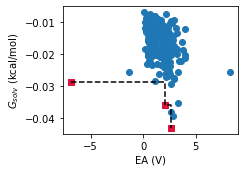

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

pareto_front = ea_results.query('is_pareto')
ax.scatter(ea_results['ea_dfb-acn-smb-geom'], ea_results['solv_eng_diffuse'])
ax.scatter(pareto_front['ea_dfb-acn-smb-geom'], pareto_front['solv_eng_diffuse'], s=35, marker='s', color='crimson')
ax.step(pareto_front['ea_dfb-acn-smb-geom'], pareto_front['solv_eng_diffuse'], 'k--', where='post')

ax.set_xlabel('EA (V)')
ax.set_ylabel('$G_{solv}$ (kcal/mol)')

fig.tight_layout()
fig.savefig('pthalimide-pareto.png', dpi=320)

In [19]:
pareto_front

,inchi,smiles,molwt,charge,ea_dfb-acn-smb-geom,solv_eng_diffuse,is_pareto,redox_dist,solv_dist
565,InChI=1S/C9H6N2O2/c10-6-4-7(12)9(13)5-2-1-3-11...,NC1=CC(=O)C(=O)c2cccnc21,174.159,0,-6.917653,-0.028673,True,0.0,0.0
532,InChI=1S/C8H12N2O2S/c1-3-4-10-8(12)7(11)6(13-2...,CCCn1[nH]cc(SC)c(=O)c1=O,200.263,0,2.094068,-0.035706,True,0.0,0.0
1368,InChI=1S/C48H24/c1-2-14-26-25(13-1)37-27-15-3-...,c1ccc2c(c1)c1c3ccccc3c3c4ccccc4c4c5ccccc5c5c6c...,600.720,0,2.630798,-0.043011,True,0.0,0.0


In [20]:
ip_results = get_dominating_solutions(results, 'ip_nob-acn-smb-geom', 'solv_eng_normal')

In [21]:
ip_results

,inchi,smiles,molwt,charge,ip_nob-acn-smb-geom,solv_eng_normal,is_pareto,redox_dist,solv_dist
706,InChI=1S/C5H3NO/c6-4-5-2-1-3-7-5/h1-3H,N#Cc1ccco1,93.085,0,10.504882,-0.009841,True,0.000000,0.000000
1819,"InChI=1S/C5H2N4/c6-1-4-3-8-9-5(4)2-7/h3H,(H,8,9)",N#Cc1cn[nH]c1C#N,118.099,0,9.117361,-0.018030,True,0.000000,0.000000
12864,"InChI=1S/C3HF3N4O2/c4-3(5,6)9-1-7-2(8-9)10(11)...",O=[N+]([O-])c1ncn(C(F)(F)F)n1,182.061,0,8.780688,-0.018426,True,0.000000,0.000000
13443,"InChI=1S/C6H4F2O3S/c7-4-2-1-3-5(8)6(4)12(9,10)...",O=S(=O)(O)c1c(F)cccc1F,194.158,0,8.569949,-0.018931,True,0.000000,0.000000
13203,"InChI=1S/C6H4N2O3S/c7-4-5-1-2-8-6(3-5)12(9,10)...",N#Cc1ccnc(S(=O)(=O)O)c1,184.176,0,8.498518,-0.024224,True,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...
1450,"InChI=1S/C8H8/c1-7-3-5-8(2)6-4-7/h3-6H,1-2H2",C=c1ccc(=C)cc1,104.152,0,5.092070,-0.007616,False,5.412811,0.002225
1347,"InChI=1S/C8H8/c1-7-5-3-4-6-8(7)2/h3-6H,1-2H2",C=c1ccccc1=C,104.152,0,4.884740,-0.007471,False,5.620142,0.002369
741,"InChI=1S/C5H7NO/c1-6-5-2-3-7-4-5/h2-4,6H,1H3",CNc1ccoc1,97.117,0,4.659149,-0.009323,False,5.845733,0.000518
727,"InChI=1S/C5H7NO/c1-6-5-3-2-4-7-5/h2-4,6H,1H3",CNc1ccco1,97.117,0,4.495525,-0.009698,False,6.009356,0.000142


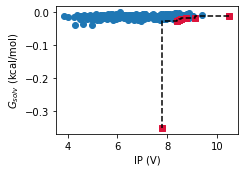

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 2.5))

pareto_front = ip_results.query('is_pareto')
ax.scatter(ip_results['ip_nob-acn-smb-geom'], ip_results['solv_eng_normal'])
ax.scatter(pareto_front['ip_nob-acn-smb-geom'], pareto_front['solv_eng_normal'], s=35, marker='s', color='crimson')
ax.step(pareto_front['ip_nob-acn-smb-geom'], pareto_front['solv_eng_normal'], 'k--', where='post')

ax.set_xlabel('IP (V)')
ax.set_ylabel('$G_{solv}$ (kcal/mol)')

fig.tight_layout()

In [23]:
pareto_front

,inchi,smiles,molwt,charge,ip_nob-acn-smb-geom,solv_eng_normal,is_pareto,redox_dist,solv_dist
706,InChI=1S/C5H3NO/c6-4-5-2-1-3-7-5/h1-3H,N#Cc1ccco1,93.085,0,10.504882,-0.009841,True,0.0,0.0
1819,"InChI=1S/C5H2N4/c6-1-4-3-8-9-5(4)2-7/h3H,(H,8,9)",N#Cc1cn[nH]c1C#N,118.099,0,9.117361,-0.018030,True,0.0,0.0
12864,"InChI=1S/C3HF3N4O2/c4-3(5,6)9-1-7-2(8-9)10(11)...",O=[N+]([O-])c1ncn(C(F)(F)F)n1,182.061,0,8.780688,-0.018426,True,0.0,0.0
13443,"InChI=1S/C6H4F2O3S/c7-4-2-1-3-5(8)6(4)12(9,10)...",O=S(=O)(O)c1c(F)cccc1F,194.158,0,8.569949,-0.018931,True,0.0,0.0
13203,"InChI=1S/C6H4N2O3S/c7-4-5-1-2-8-6(3-5)12(9,10)...",N#Cc1ccnc(S(=O)(=O)O)c1,184.176,0,8.498518,-0.024224,True,0.0,0.0
13164,"InChI=1S/C6H4N2O3S/c7-4-5-2-1-3-8-6(5)12(9,10)...",N#Cc1cccnc1S(=O)(=O)O,184.176,0,8.398387,-0.025426,True,0.0,0.0
1884,InChI=1S/C5H2N2O2/c6-1-5-4(3-8)2-7-9-5/h2-3H,N#Cc1oncc1C=O,122.083,0,7.809750,-0.350256,True,0.0,0.0


## Save them to disk
Let's make a memorable filename and dump accordingly

In [24]:
filename = datetime.now().strftime('%y%m%d')  # Start with the date

In [25]:
if neutral:   # Mark whether we only output the neutrals
    filename += "-neutral_only"

In [26]:
if subset:
    filename += f'-subset_{subset}'

In [27]:
if filter_path:
    filename += '-filter_' + filter_path.name[:-4]

In [28]:
print(f'Filename postfix: {filename}')

Filename postfix: 220609-neutral_only-subset_ZINC15-filter_round2.1


Save the data to a collection folder

In [29]:
output_folder = Path('results')
output_folder.mkdir(exist_ok=True)

In [30]:
ea_results.to_csv(output_folder / f'anolytes-{filename}.csv', index=False)

In [31]:
ip_results.to_csv(output_folder / f'catholytes-{filename}.csv', index=False)